## Pakete und Dateien einladen

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy.stats as stats
import numpy as np
import seaborn as sns
import os
import missingno as msno
from fancyimpute import IterativeImputer, KNN

CSV Datein in dataframes einladen und erste Zeilen aller DF ausgeben

In [31]:
url1 = "https://raw.githubusercontent.com/FabsenMc/bakery_prediction/main/0_DataPreparation/kiwo.csv"
url2 = "https://raw.githubusercontent.com/FabsenMc/bakery_prediction/main/0_DataPreparation/umsatzdaten_gekuerzt.csv"
url3 = "https://raw.githubusercontent.com/FabsenMc/bakery_prediction/main/0_DataPreparation/wetter.csv"
url4 = "https://raw.githubusercontent.com/FabsenMc/bakery_prediction/main/0_DataPreparation/Wettercodes.csv"
url5 = "https://raw.githubusercontent.com/FabsenMc/bakery_prediction/main/0_DataPreparation/fuf_v2.csv"
url6 = "https://raw.githubusercontent.com/FabsenMc/bakery_prediction/main/0_DataPreparation/thw-kiel-spieltage.csv"
url7 = "https://raw.githubusercontent.com/FabsenMc/bakery_prediction/main/0_DataPreparation/kieler_umschlag.csv"
url8 = "https://raw.githubusercontent.com/FabsenMc/bakery_prediction/main/0_DataPreparation/weihnachtsmarkt.csv"
url19 = "https://raw.githubusercontent.com/FabsenMc/bakery_prediction/main/0_DataPreparation/Verbraucherpreisindex.csv"

# Überführen der Daten in DataFrames
daten = pd.read_csv(url1) # Daten der Kiwo
umswar = pd.read_csv(url2) # Umsätze der Warengruppen
wetter = pd.read_csv(url3) # Wetterdaten der Kiwos
wetterc = pd.read_csv(url4) # Wettercodes
ferien = pd.read_csv(url5) # Feriendaten
thw = pd.read_csv(url6) # THW Kiel Spieltage
kium = pd.read_csv(url7) # Kieler Umschlag Tage
weima = pd.read_csv(url8) # Weihnachtsmarkt Tage
verbraucherpreisindex = pd.read_csv(url19) # Verbraucherpreisindex

# Anzeige der ersten Zeilen der DataFrames
print(daten.head()) # Ausgabe der ersten 5 Zeilen
print(umswar.head()) # Ausgabe der ersten 5 Zeilen 
print(wetter.head()) # Ausgabe der ersten 5 Zeilen
print(wetterc.head()) # Ausgabe der ersten 5 Zeilen
print(ferien.head()) # Ausgabe der ersten 5 Zeilen
print(thw.head()) # Ausgabe der ersten 5 Zeilen
print(kium.head()) # Ausgabe der ersten 5 Zeilen
print(weima.head()) # Ausgabe der ersten 5 Zeilen
print(verbraucherpreisindex.head())

        Datum  KielerWoche
0  2012-06-16            1
1  2012-06-17            1
2  2012-06-18            1
3  2012-06-19            1
4  2012-06-20            1
        Datum  Warengruppe      Umsatz
0  2013-07-01            1  148.828353
1  2013-07-02            1  159.793757
2  2013-07-03            1  111.885594
3  2013-07-04            1  168.864941
4  2013-07-05            1  171.280754
        Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode
0  2012-01-01         8.0      9.8250                   14        58.0
1  2012-01-02         7.0      7.4375                   12         NaN
2  2012-01-03         8.0      5.5375                   18        63.0
3  2012-01-04         4.0      5.6875                   19        80.0
4  2012-01-05         6.0      5.3000                   23        80.0
   Wettercode                             Beschreibung
0           0  Bewoelkungsentwicklung nicht beobachtet
1           1                     Bewoelkung abnehmend
2           2

## Notwendige Formatierung der zusätzlichen Datensätze
Da nach der Betrachtung der ersten Zeilen direkt auffällt, dass der Datensatz des Verbraucherpreisindex in anderem Format ist, wird dieser angepasst

In [32]:
# Ersetzten der Kommas als Zahlentrennzeichen mit Punkten

# Definieren der Spalten, die formatiert werden sollen
numeric_columns = ['Verbraucherpreisindex', 'Veränderung zum Vorjahresmonat', 'Veränderung zum Vormonat']

# Ersetzen der Kommas und umwandeln in numerisches Format
for col in numeric_columns:
    verbraucherpreisindex[col] = verbraucherpreisindex[col].str.replace(',', '.', regex=False) 
    verbraucherpreisindex[col] = pd.to_numeric(verbraucherpreisindex[col], errors='coerce')

print("DataFrame nach Formatierung:")
print(verbraucherpreisindex.head())
print(verbraucherpreisindex.dtypes)

# Dropen der ersten Zeile und der Spalte Unnamed, sowie den Spalten Veränderung zum Vorjahresmonat da diese nicht gebraucht werden 
verbraucherpreisindex = verbraucherpreisindex.drop(index=0)
verbraucherpreisindex = verbraucherpreisindex.drop(columns=['Unnamed: 0', 'Veränderung zum Vorjahresmonat', 'Veränderung zum Vormonat'])
print(verbraucherpreisindex.head())

# Auch die Datumsspalte muss angepasst werden, da es bisher nur zwei gibt
month_map = {
    'Januar': '01', 'Februar': '02', 'März': '03', 'April': '04',
    'Mai': '05', 'Juni': '06', 'Juli': '07', 'August': '08',
    'September': '09', 'Oktober': '10', 'November': '11', 'Dezember': '12'
}
# Ersetzen der Monatsnamen mit Nummern 
verbraucherpreisindex['Monat'] = verbraucherpreisindex['Monat'].map(month_map)

# Erstellen einer Datumsspalte
verbraucherpreisindex['Datum'] = verbraucherpreisindex['Jahr'].astype(str) + '-' + verbraucherpreisindex['Monat'] + '-01'

# Konvertieren der Datumsspalte in Datumsformat
verbraucherpreisindex['Datum'] = pd.to_datetime(verbraucherpreisindex['Datum'])

# Drop the original "Jahr" and "Monat" columns if they are no longer needed
verbraucherpreisindex = verbraucherpreisindex.drop(columns=['Jahr', 'Monat'])

#drop der nicht benötigten Jahre
# drop the years 1991-2011
verbraucherpreisindex = verbraucherpreisindex[verbraucherpreisindex['Datum'].dt.year >= 2012]
verbraucherpreisindex = verbraucherpreisindex[verbraucherpreisindex['Datum'].dt.year <2020].reset_index(drop=True)
print("DataFrame after dropping rows for years 1991-2011:")
print(verbraucherpreisindex.head())

# Überführen des Dataframes in einen Dataframe mit Datumreihe in Tagesformat, nicht mehr Monatsformat
date_range = pd.date_range(start=verbraucherpreisindex['Datum'].min(), end=verbraucherpreisindex['Datum'].max(), freq='D')
daily_df = pd.DataFrame(date_range, columns=['Datum'])
vpi = daily_df.merge(verbraucherpreisindex, on='Datum', how='left')
vpi['Verbraucherpreisindex'] = vpi['Verbraucherpreisindex'].ffill()
print(vpi.head())

# Umändern der Datumszeile zurück zu string,um merge in großem dataframe zu gewährleisten
vpi['Datum'] = vpi['Datum'].dt.strftime('%Y-%m-%d')

DataFrame nach Formatierung:
   Unnamed: 0  Jahr    Monat  Verbraucherpreisindex  \
0           0   NaN      NaN                    NaN   
1           1  1991   Januar                   60.5   
2           2  1991  Februar                   60.8   
3           3  1991     März                   60.8   
4           4  1991    April                   61.0   

   Veränderung zum Vorjahresmonat  Veränderung zum Vormonat  
0                             NaN                       NaN  
1                             NaN                       NaN  
2                             NaN                       0.5  
3                             NaN                       NaN  
4                             NaN                       0.3  
Unnamed: 0                          int64
Jahr                               object
Monat                              object
Verbraucherpreisindex             float64
Veränderung zum Vorjahresmonat    float64
Veränderung zum Vormonat          float64
dtype: object
  

Configurieren der Datenformate und mergen der DF

In [33]:
# Convert the date format from DD.MM.YYYY to MM/DD/YYYY
ferien['Datum'] = pd.to_datetime(ferien['Datum'], dayfirst=True).dt.strftime('%Y-%m-%d')

# Die 3 DataFrames zusammenführen (mergen) in einen neuen gemeinsamen DataFrame mit der Methode "outer"
dataf = daten.merge(umswar, on="Datum", how = "outer") \
             .merge(wetter, on="Datum", how = "outer") \
             .merge(wetterc, on="Wettercode", how = "left") \
             .merge(ferien, on="Datum", how = "outer") \
             .merge(thw, on="Datum", how = "outer") \
             .merge(kium, on="Datum", how = "outer") \
             .merge(weima, on="Datum", how = "outer") \
             .merge(vpi, on="Datum", how="outer")

# Ausgabe der ersten 5 Zeilen des neuen DataFrames
print(dataf.head())

        Datum  KielerWoche  Warengruppe  Umsatz  Bewoelkung  Temperatur  \
0  2012-01-01          NaN          NaN     NaN         8.0      9.8250   
1  2012-01-02          NaN          NaN     NaN         7.0      7.4375   
2  2012-01-03          NaN          NaN     NaN         8.0      5.5375   
3  2012-01-04          NaN          NaN     NaN         4.0      5.6875   
4  2012-01-05          NaN          NaN     NaN         6.0      5.3000   

   Windgeschwindigkeit  Wettercode                    Beschreibung  FerienSH  \
0                 14.0        58.0  leichter Spruehregen mit Regen       1.0   
1                 12.0         NaN                             NaN       1.0   
2                 18.0        63.0     durchgehend maessiger Regen       1.0   
3                 19.0        80.0           leichter Regenschauer       1.0   
4                 23.0        80.0           leichter Regenschauer       1.0   

   Feiertag Uhrzeit Heim_Auswärts  Umschlag  Weihnachtsmarkt  \
0   

### Feature Engineering

In [34]:
# Hinzufügen einer zusätzlichen Spalte Regen ja/nein
dataf["Regen"] = dataf["Beschreibung"].str.contains("Regen", case=False, na=False)
dataf["Regen"] = dataf["Regen"].map({True: 1, False: 0})

# Hinzufügen einer zusätzlichen Spalte Schnee ja/nein
dataf["Schnee"] = dataf["Beschreibung"].str.contains("Schnee", case=False, na=False)
dataf["Schnee"] = dataf["Schnee"].map({True: 1, False: 0})

# Hinzufügen einer zusätzlichen Spalte mit den Wochentagen
dataf["Datum"] = pd.to_datetime(dataf["Datum"])
dataf["Wochentag_MDMDFSS"] = dataf["Datum"].dt.weekday
#dataf["Wochentag"] = dataf["Wochentag"].map({0: "Montag", 1: "Dienstag", 2: "Mittwoch", 3: "Donnerstag", 4: "Freitag", 5: "Samstag", 6: "Sonntag"}) #-> der ML Algorythmus kann ja nur mit Zahlen umgehen

# Hinzufügen einer zusätzlichen Spalte mit den Wochenenden
dataf["Wochenende"] = dataf["Wochentag_MDMDFSS"].map({0 : 0, 1 : 0, 2 : 0, 3 : 0, 4 : 0, 5 : 1, 6 : 1})

# Hinzufügen einer zusätzlichen Spalte mit den Jahreszeiten Frühling Sommer Herbst und Winter (FSHW) in Abhängigkeit des Datums
dataf["Jahreszeit_FSHW"] = dataf["Datum"].dt.month
dataf["Jahreszeit_FSHW"] = dataf["Datum"].dt.month.map({1: 4, 2: 4, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 4})

# Hinzufügen einer zusätzlichen Spalte Temperatur Kategorie # min -10, max: 32
if 'Temperatur_Kategorie' in dataf.columns:
    dataf.drop(columns=['Temperatur_Kategorie'], inplace=True)
# Define the bin edges
bins = [-10, 10, 20, 35]
# Define the bin labels
labels = ['1', '2', '3']

# Use pd.cut() to create the new column "Temperatur_Kategorie"
dataf['Temperatur_Kategorie'] = pd.cut(dataf['Temperatur'], bins=bins, labels=labels)

# Ausgabe der ersten 5 Zeilen des gemergten DataFrames
print(dataf.head())

       Datum  KielerWoche  Warengruppe  Umsatz  Bewoelkung  Temperatur  \
0 2012-01-01          NaN          NaN     NaN         8.0      9.8250   
1 2012-01-02          NaN          NaN     NaN         7.0      7.4375   
2 2012-01-03          NaN          NaN     NaN         8.0      5.5375   
3 2012-01-04          NaN          NaN     NaN         4.0      5.6875   
4 2012-01-05          NaN          NaN     NaN         6.0      5.3000   

   Windgeschwindigkeit  Wettercode                    Beschreibung  FerienSH  \
0                 14.0        58.0  leichter Spruehregen mit Regen       1.0   
1                 12.0         NaN                             NaN       1.0   
2                 18.0        63.0     durchgehend maessiger Regen       1.0   
3                 19.0        80.0           leichter Regenschauer       1.0   
4                 23.0        80.0           leichter Regenschauer       1.0   

   ...  Heim_Auswärts Umschlag Weihnachtsmarkt  Verbraucherpreisindex  Reg

## Data Transformation 
Umwandeln der Variablen in den richtigen Type: 
Umgewandelt werden in Kategoriale Variablen müssen: KielerWoche, FerienSH, Feiertag, Warengruppe??

In [35]:
print(dataf.dtypes)

Datum                    datetime64[ns]
KielerWoche                     float64
Warengruppe                     float64
Umsatz                          float64
Bewoelkung                      float64
Temperatur                      float64
Windgeschwindigkeit             float64
Wettercode                      float64
Beschreibung                     object
FerienSH                        float64
Feiertag                        float64
Uhrzeit                          object
Heim_Auswärts                    object
Umschlag                        float64
Weihnachtsmarkt                 float64
Verbraucherpreisindex           float64
Regen                             int64
Schnee                            int64
Wochentag_MDMDFSS                 int32
Wochenende                        int64
Jahreszeit_FSHW                   int64
Temperatur_Kategorie           category
dtype: object


In [36]:
# Umwandeln der THW - Variable
dataf['THW_heimspiel'] = dataf['Heim_Auswärts'].apply(lambda x:1 if x == 'H' else 0)


In [37]:
# Umwandeln der NaNs in 0
dataf['KielerWoche'] = dataf['KielerWoche'].fillna(0)
dataf['Weihnachtsmarkt'] = dataf['Weihnachtsmarkt'].fillna(0)
dataf['Umschlag'] = dataf['Umschlag'].fillna(0)

# Umwandeln der NANs in der KielerWoche Variable sowie in der Weihnachtsmarkt und Umschlag Variable in 0
dataf['KielerWoche'] = dataf['KielerWoche'].astype(int)
dataf['Weihnachtsmarkt'] = dataf['Weihnachtsmarkt'].astype(int)
dataf['Umschlag'] = dataf['Umschlag'].astype(int)
# Erstellen einer Liste aller kategorieller Variablen 
categorical_columns = ['KielerWoche', 'Weihnachtsmarkt', 'Umschlag', 'Feiertag', 'FerienSH',
                       'Warengruppe', 'Wochentag_MDMDFSS', 'Wochenende', 'Regen', 'Schnee',
                       'Jahreszeit_FSHW', 'THW_heimspiel']
# Konvertieren der Spalten zu kategorischen Variablen
dataf[categorical_columns] = dataf[categorical_columns].astype('category')

print(dataf.dtypes)  # Okay das ist etwas unnötig an dieser Stelle, da wir das ganze ja wieder als csv speichern und in den Notebooks als csv reinladen  
                      # - am Anfang jedes Notebooks müsste daher eigentlich einmal diese variablen umgeändert werden

Datum                    datetime64[ns]
KielerWoche                    category
Warengruppe                    category
Umsatz                          float64
Bewoelkung                      float64
Temperatur                      float64
Windgeschwindigkeit             float64
Wettercode                      float64
Beschreibung                     object
FerienSH                       category
Feiertag                       category
Uhrzeit                          object
Heim_Auswärts                    object
Umschlag                       category
Weihnachtsmarkt                category
Verbraucherpreisindex           float64
Regen                          category
Schnee                         category
Wochentag_MDMDFSS              category
Wochenende                     category
Jahreszeit_FSHW                category
Temperatur_Kategorie           category
THW_heimspiel                  category
dtype: object


## Missing Values Imputation

Abfrage, bei welcher Variable wie viele Werte NaNs auftauchen, um einen Eindruck zu bekommen welches Imputationsverfahren das geeignetste ist.

In [38]:
missing_values_per_column = dataf.isna().sum()
print("Missing values per column:\n", missing_values_per_column)

Missing values per column:
 Datum                       0
KielerWoche                 0
Warengruppe              1103
Umsatz                   1103
Bewoelkung                389
Temperatur                334
Windgeschwindigkeit       334
Wettercode               2856
Beschreibung             2856
FerienSH                   38
Feiertag                   38
Uhrzeit                  9531
Heim_Auswärts            9526
Umschlag                    0
Weihnachtsmarkt             0
Verbraucherpreisindex      30
Regen                       0
Schnee                      0
Wochentag_MDMDFSS           0
Wochenende                  0
Jahreszeit_FSHW             0
Temperatur_Kategorie      335
THW_heimspiel               0
dtype: int64


Die Masken müssten denke ich verschieden heißen, damit die Info darin nicht bei jeder Zeile wieder überschrieben wird (Fabian)

In [39]:
# Create a mask for the imputed values
mask = dataf['KielerWoche'].isna()  # mask for missing values in 'KielerWoche'
mask = dataf['Warengruppe'].isna()  # mask for missing values in 'Warengruppe'
mask = dataf['Umsatz'].isna()  # mask for missing values in 'Umsatz'
mask = dataf['Bewoelkung'].isna()  # mask for missing values in 'Bewoelkung'
mask = dataf['Temperatur'].isna()  # mask for missing values in 'Temperatur'
mask = dataf['Windgeschwindigkeit'].isna()  # mask for missing values in 'Windgeschwindigkeit'
mask = dataf['Wettercode'].isna()  # mask for missing values in 'Wettercode'
mask = dataf['Beschreibung'].isna()  # mask for missing values in 'Beschreibung'
mask = dataf['FerienSH'].isna()  # mask for missing values in 'FerienSH'
mask = dataf['Feiertag'].isna()  # mask for missing values in 'Feiertag'
mask = dataf['Uhrzeit'].isna()  # mask for missing values in 'Uhrzeit'
mask = dataf['Beschreibung'].isna()  # mask for missing values in 'Beschreibung'
mask = dataf['Heim_Auswärts'].isna()  # mask for missing values in 'Heim_Auswärts'
mask = dataf['Umschlag'].isna()  # mask for missing values in 'Umschlag'
mask = dataf['Weihnachtsmarkt'].isna()  # mask for missing values in 'Weihnachtsmarkt'
mask = dataf['Temperatur_Kategorie'].isna()  # mask for missing values in 'Temperatur_Kategorie'

In [40]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from fancyimpute import IterativeImputer, KNN

In [41]:
# print dataframe to visualize the dataframe
print(dataf)

           Datum KielerWoche Warengruppe  Umsatz  Bewoelkung  Temperatur  \
0     2012-01-01           0         NaN     NaN         8.0      9.8250   
1     2012-01-02           0         NaN     NaN         7.0      7.4375   
2     2012-01-03           0         NaN     NaN         8.0      5.5375   
3     2012-01-04           0         NaN     NaN         4.0      5.6875   
4     2012-01-05           0         NaN     NaN         6.0      5.3000   
...          ...         ...         ...     ...         ...         ...   
10432 2019-12-27           0         NaN     NaN         NaN         NaN   
10433 2019-12-28           0         NaN     NaN         NaN         NaN   
10434 2019-12-29           0         NaN     NaN         NaN         NaN   
10435 2019-12-30           0         NaN     NaN         NaN         NaN   
10436 2019-12-31           0         NaN     NaN         NaN         NaN   

       Windgeschwindigkeit  Wettercode                    Beschreibung  \
0            

In [42]:
# Save columns "datum" und "uhrzeit"
datum_col= dataf['Datum']
uhrzeit_col = dataf['Uhrzeit']
Beschreibung_col = dataf['Beschreibung']
Heim_Auswärts_col = dataf['Heim_Auswärts']

# delete columns "datum" und "uhrzeit" from dataf
dataf_without = dataf.drop(['Datum', 'Uhrzeit','Beschreibung','Heim_Auswärts'], axis=1)

# Conduct Imputation
imputer_knn = KNN()
dataf_knn_without = pd.DataFrame(imputer_knn.fit_transform(dataf_without), columns=dataf_without.columns)
dataf_knn_without['Windgeschwindigkeit'] = dataf_knn_without['Windgeschwindigkeit'].round().astype(int).clip(lower=0, upper=35)
dataf_knn_without['Warengruppe'] = dataf_knn_without['Warengruppe'].round().astype(int).clip(lower=0, upper=6)
dataf_knn_without['Wettercode'] = dataf_knn_without['Wettercode'].round().astype(int).clip(lower=0, upper=90)
dataf_knn_without['Bewoelkung'] = dataf_knn_without['Bewoelkung'].round().astype(int).clip(lower=0, upper=8)
dataf_knn_without['FerienSH'] = dataf_knn_without['FerienSH'].round().astype(int).clip(lower=0, upper=1)
dataf_knn_without['Jahreszeit_FSHW'] = dataf_knn_without['Jahreszeit_FSHW'].round().astype(int).clip(lower=1, upper=4)
dataf_knn_without['FerienSH'] = dataf_knn_without['FerienSH'].round().astype(int).clip(lower=0, upper=1)
dataf_knn_without['Wochentag_MDMDFSS'] = dataf_knn_without['Wochentag_MDMDFSS'].round().astype(int).clip(lower=1, upper=7)
dataf_knn_without['Wochenende'] = dataf_knn_without['Wochenende'].round().astype(int).clip(lower=0, upper=1)
dataf_knn_without['THH_heimspiel'] = dataf_knn_without['THW_heimspiel'].round().astype(int).clip(lower=0, upper=1)
dataf_knn_without['Temperatur_Kategorie'] = dataf_knn_without['Temperatur_Kategorie'].round().astype(int).clip(lower=1, upper=3)
dataf_knn_without['Regen'] = dataf_knn_without['Regen'].round().astype(int).clip(lower=0, upper=1)
dataf_knn_without['Schnee'] = dataf_knn_without['Schnee'].round().astype(int).clip(lower=0, upper=1)
dataf_knn_without['Feiertag'] = dataf_knn_without['Feiertag'].round().astype(int).clip(lower=0, upper=1)

Imputing row 1/10437 with 2 missing, elapsed time: 17.277
Imputing row 101/10437 with 2 missing, elapsed time: 17.286
Imputing row 201/10437 with 2 missing, elapsed time: 17.294
Imputing row 301/10437 with 7 missing, elapsed time: 17.303
Imputing row 401/10437 with 7 missing, elapsed time: 17.318
Imputing row 501/10437 with 2 missing, elapsed time: 17.336
Imputing row 601/10437 with 0 missing, elapsed time: 17.342
Imputing row 701/10437 with 1 missing, elapsed time: 17.346
Imputing row 801/10437 with 1 missing, elapsed time: 17.348
Imputing row 901/10437 with 0 missing, elapsed time: 17.351
Imputing row 1001/10437 with 0 missing, elapsed time: 17.353
Imputing row 1101/10437 with 0 missing, elapsed time: 17.356
Imputing row 1201/10437 with 0 missing, elapsed time: 17.357
Imputing row 1301/10437 with 1 missing, elapsed time: 17.359
Imputing row 1401/10437 with 0 missing, elapsed time: 17.360
Imputing row 1501/10437 with 1 missing, elapsed time: 17.362
Imputing row 1601/10437 with 0 missi

In [43]:
# merge dataf_knn_without and datum_col 
dataf_knn = pd.concat([datum_col, dataf_knn_without], axis=1)

In [44]:
#  print dataf_knn
print(dataf_knn)

           Datum  KielerWoche  Warengruppe      Umsatz  Bewoelkung  \
0     2012-01-01          0.0            4  129.473516           8   
1     2012-01-02          0.0            3  179.073831           7   
2     2012-01-03          0.0            3  181.361481           8   
3     2012-01-04          0.0            3  161.093549           4   
4     2012-01-05          0.0            3  184.942302           6   
...          ...          ...          ...         ...         ...   
10432 2019-12-27          0.0            3  225.702652           4   
10433 2019-12-28          0.0            2  205.724369           7   
10434 2019-12-29          0.0            3  293.287758           5   
10435 2019-12-30          0.0            3  206.214352           4   
10436 2019-12-31          0.0            3  653.851389           5   

       Temperatur  Windgeschwindigkeit  Wettercode  FerienSH  Feiertag  ...  \
0          9.8250                   14          58         1         1  ...   
1

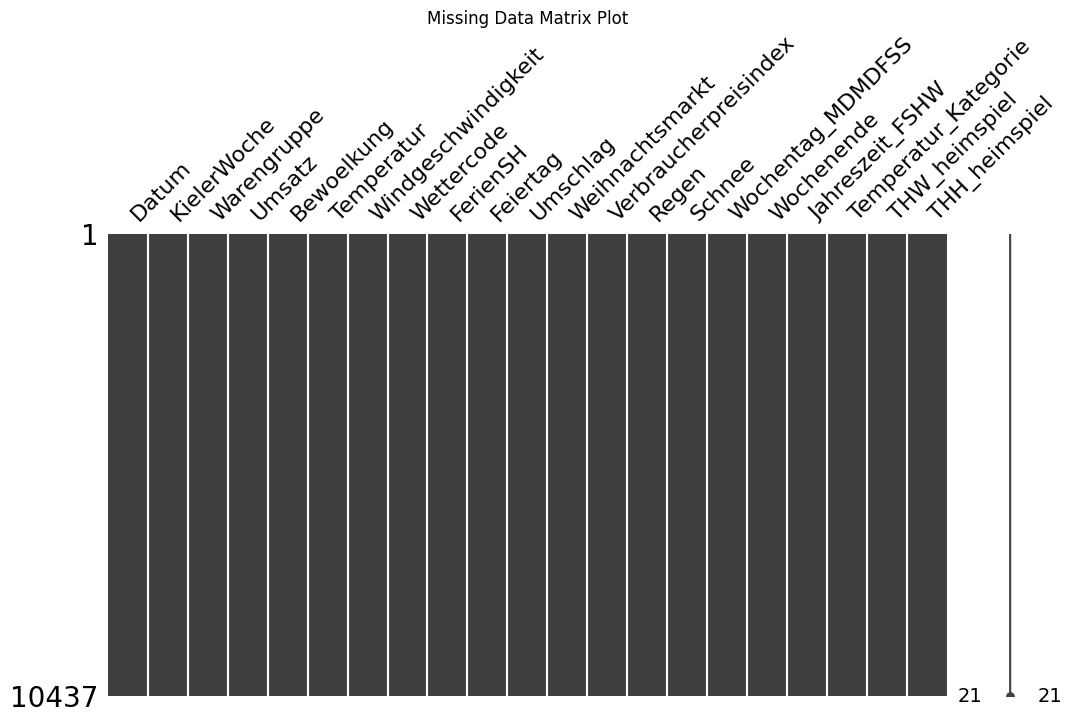

In [45]:
# Matrix plot of missing data
msno.matrix(dataf_knn, figsize=(12, 6))
plt.title('Missing Data Matrix Plot')
plt.show()

In [46]:
# Define a function for scatter plots that highlights imputed values
def plot_scatter_with_imputation(data, x, y, mask, title='Scatter Plot', xlabel='X-axis', ylabel='Y-axis'):
    plt.figure(figsize=(10, 6))
    # Plot non-imputed points
    sns.scatterplot(x=data.loc[~mask, x], y=data.loc[~mask, y], color='blue', label='Original')
    # Plot imputed points
    sns.scatterplot(x=data.loc[mask, x], y=data.loc[mask, y], color='red', label='Imputed')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()

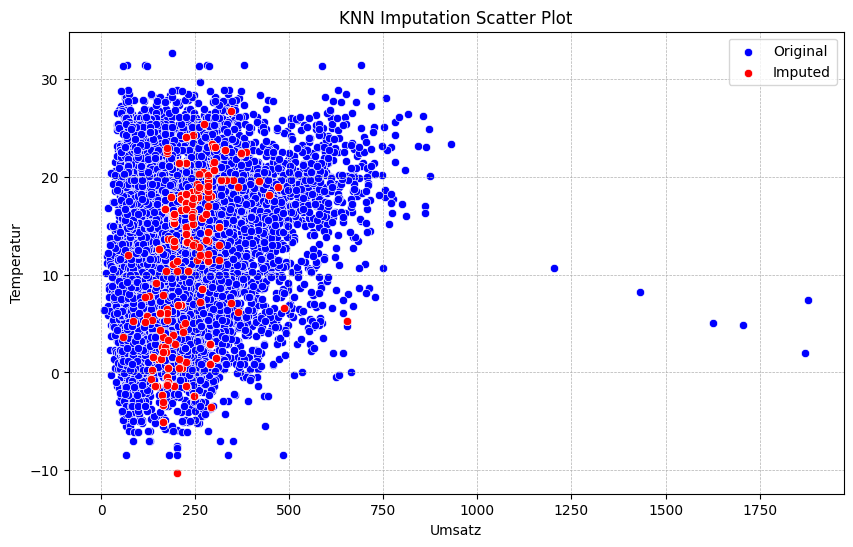

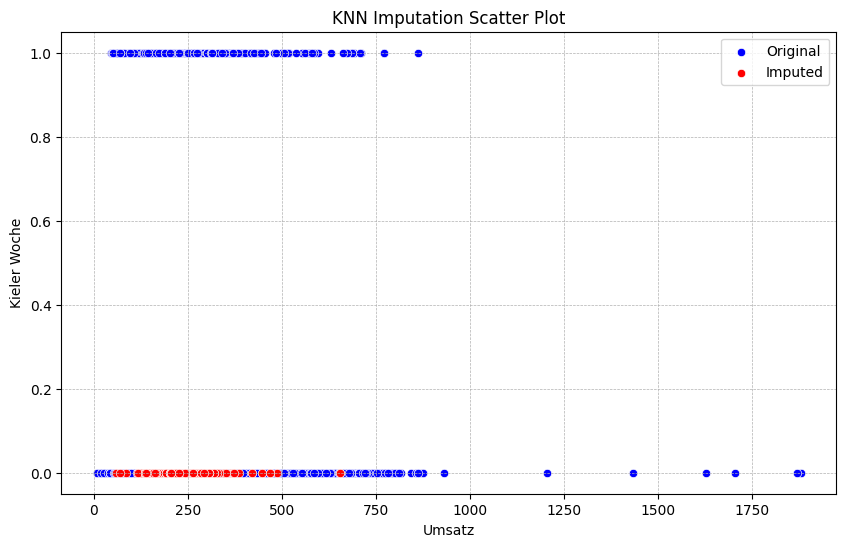

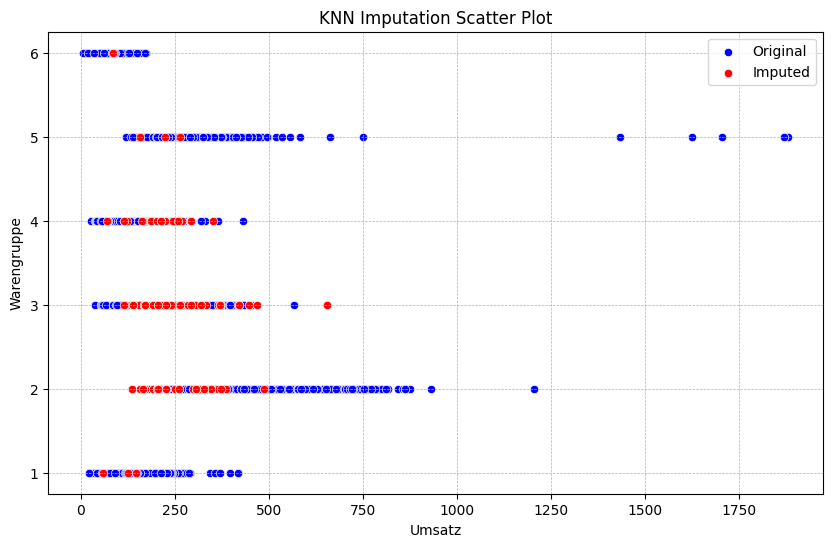

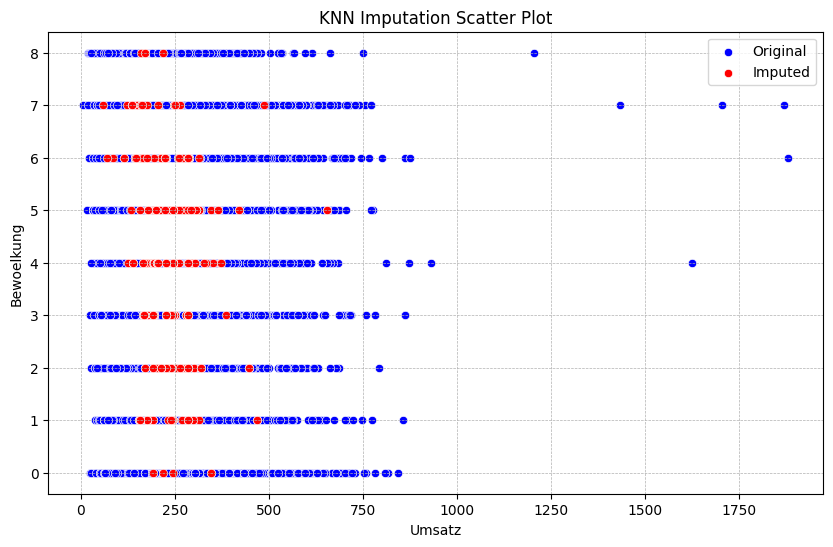

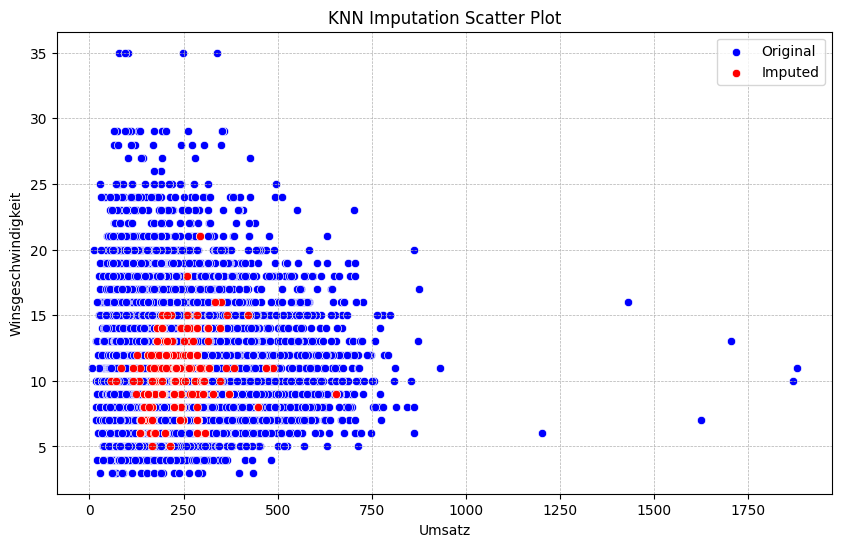

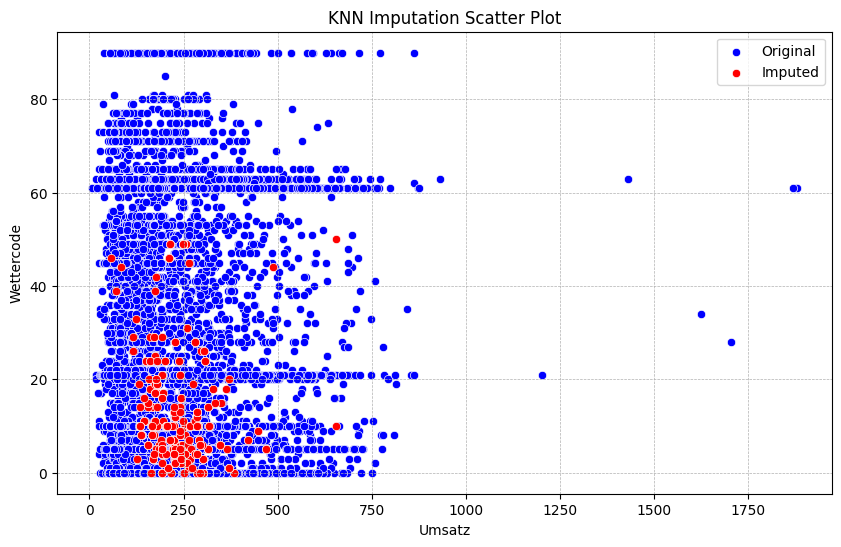

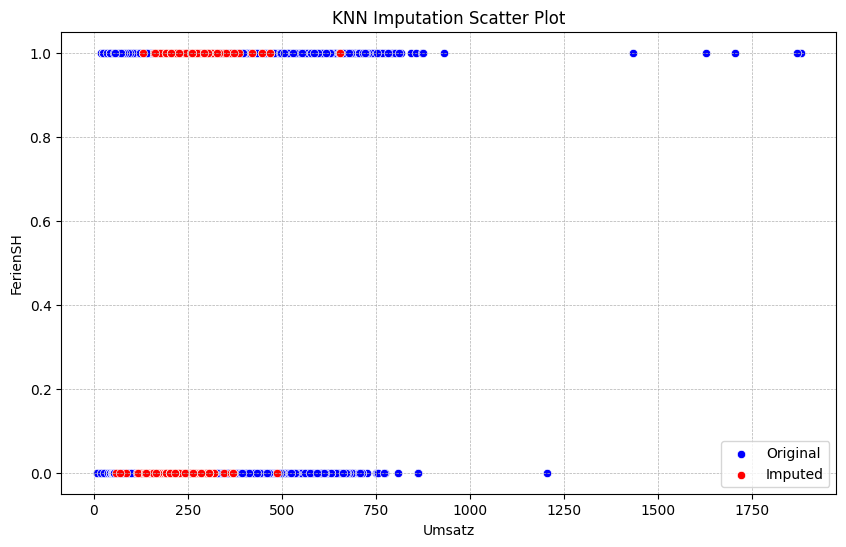

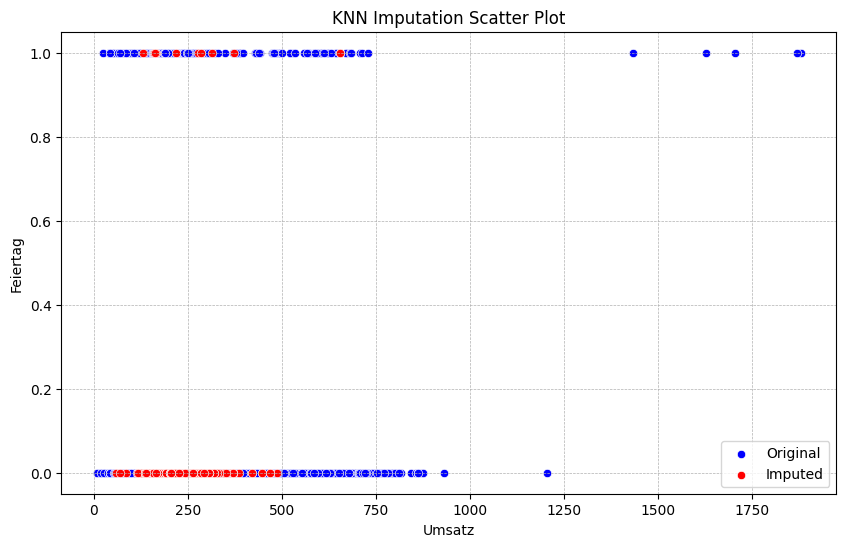

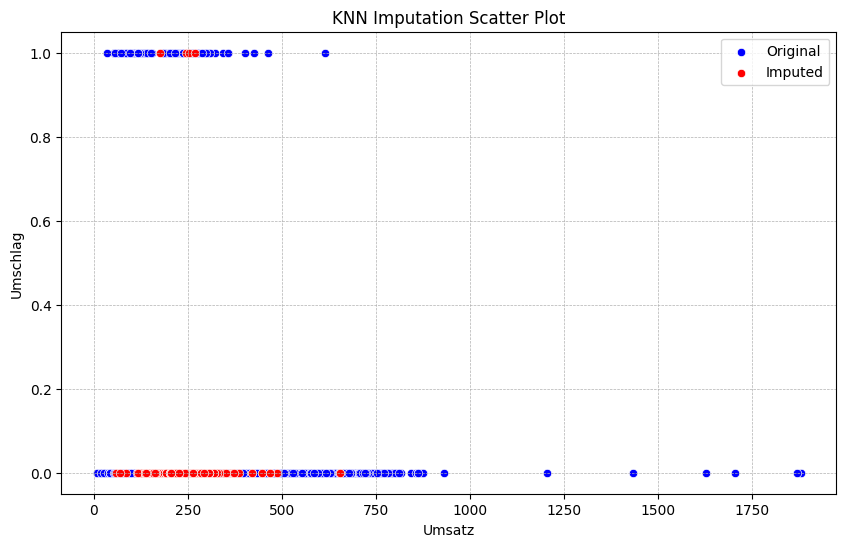

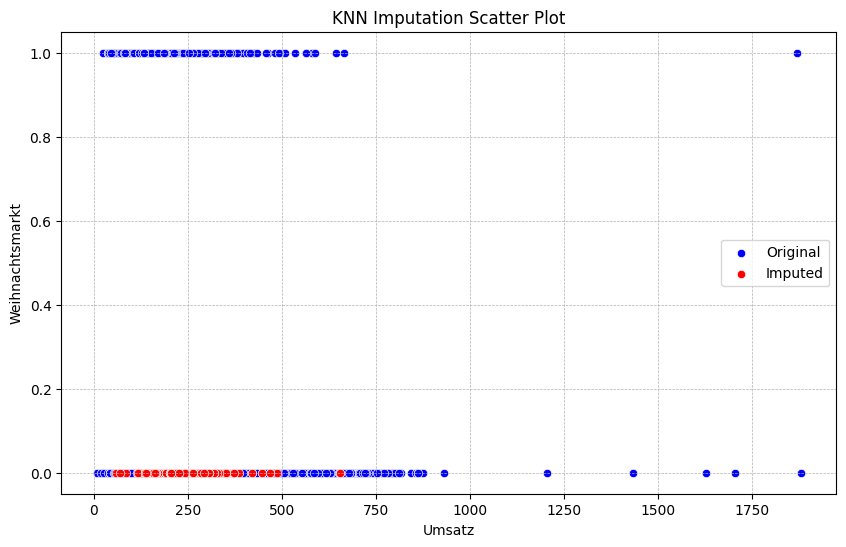

In [47]:
# Plotting results for KNN imputation
plot_scatter_with_imputation(dataf_knn, 'Umsatz', 'Temperatur', mask, 'KNN Imputation Scatter Plot', 'Umsatz', 'Temperatur')

# Plotting results for KNN imputation
plot_scatter_with_imputation(dataf_knn, 'Umsatz', 'KielerWoche', mask, 'KNN Imputation Scatter Plot', 'Umsatz', 'Kieler Woche')#

# Plotting results for KNN imputation
plot_scatter_with_imputation(dataf_knn, 'Umsatz', 'Warengruppe', mask, 'KNN Imputation Scatter Plot', 'Umsatz', 'Warengruppe')

# Plotting results for KNN imputation
plot_scatter_with_imputation(dataf_knn, 'Umsatz', 'Bewoelkung', mask, 'KNN Imputation Scatter Plot', 'Umsatz', 'Bewoelkung')

# Plotting results for KNN imputation
plot_scatter_with_imputation(dataf_knn, 'Umsatz', 'Windgeschwindigkeit', mask, 'KNN Imputation Scatter Plot', 'Umsatz', 'Winsgeschwindigkeit')

# Plotting results for KNN imputation
plot_scatter_with_imputation(dataf_knn, 'Umsatz', 'Wettercode', mask, 'KNN Imputation Scatter Plot', 'Umsatz', 'Wettercode')

# Plotting results for KNN imputation
plot_scatter_with_imputation(dataf_knn, 'Umsatz', 'FerienSH', mask, 'KNN Imputation Scatter Plot', 'Umsatz', 'FerienSH')

# Plotting results for KNN imputation
plot_scatter_with_imputation(dataf_knn, 'Umsatz', 'Feiertag', mask, 'KNN Imputation Scatter Plot', 'Umsatz', 'Feiertag')

# Plotting results for KNN imputation
plot_scatter_with_imputation(dataf_knn, 'Umsatz', 'Umschlag', mask, 'KNN Imputation Scatter Plot', 'Umsatz', 'Umschlag')

# Plotting results for KNN imputation
plot_scatter_with_imputation(dataf_knn, 'Umsatz', 'Weihnachtsmarkt', mask, 'KNN Imputation Scatter Plot', 'Umsatz', 'Weihnachtsmarkt')


Speichern des DF

In [48]:
# Speichern des DataFrames als CSV im aktuellen Arbeitsverzeichnis
current_directory = os.getcwd()
csv_file_path = os.path.join(current_directory, "dataf_knn.csv")
dataf_knn.to_csv(csv_file_path, index=False)
print(f"DataFrame wurde als CSV-Datei unter '{csv_file_path}' gespeichert.")

# Laden des DataFrames zur Überprüfung
dataf_knn_loaded = pd.read_csv(csv_file_path)
print(dataf_knn_loaded.head())

DataFrame wurde als CSV-Datei unter '/workspaces/bakery_prediction/0_DataPreparation/dataf_knn.csv' gespeichert.
        Datum  KielerWoche  Warengruppe      Umsatz  Bewoelkung  Temperatur  \
0  2012-01-01          0.0            4  129.473516           8      9.8250   
1  2012-01-02          0.0            3  179.073831           7      7.4375   
2  2012-01-03          0.0            3  181.361481           8      5.5375   
3  2012-01-04          0.0            3  161.093549           4      5.6875   
4  2012-01-05          0.0            3  184.942302           6      5.3000   

   Windgeschwindigkeit  Wettercode  FerienSH  Feiertag  ...  Weihnachtsmarkt  \
0                   14          58         1         1  ...              0.0   
1                   12          65         1         0  ...              0.0   
2                   18          63         1         0  ...              0.0   
3                   19          80         1         0  ...              0.0   
4           

In [49]:
print(dataf_knn)

           Datum  KielerWoche  Warengruppe      Umsatz  Bewoelkung  \
0     2012-01-01          0.0            4  129.473516           8   
1     2012-01-02          0.0            3  179.073831           7   
2     2012-01-03          0.0            3  181.361481           8   
3     2012-01-04          0.0            3  161.093549           4   
4     2012-01-05          0.0            3  184.942302           6   
...          ...          ...          ...         ...         ...   
10432 2019-12-27          0.0            3  225.702652           4   
10433 2019-12-28          0.0            2  205.724369           7   
10434 2019-12-29          0.0            3  293.287758           5   
10435 2019-12-30          0.0            3  206.214352           4   
10436 2019-12-31          0.0            3  653.851389           5   

       Temperatur  Windgeschwindigkeit  Wettercode  FerienSH  Feiertag  ...  \
0          9.8250                   14          58         1         1  ...   
1

In [50]:
#DF nach Datum sortieren
dataf_knn = dataf_knn.sort_values(by='Datum')

# Definieren der Datumsgrenzen
train_start_date = '2013-07-01'
train_end_date = '2017-07-31'
validation_end_date = '2018-07-31'
test_start_date ='2018-08-01'
test_end_date ='2019-12-31'

# Splitten der Daten basierend auf den Datumsgrenzen
train_data = dataf_knn[(dataf_knn['Datum']>= train_start_date) & (dataf_knn['Datum'] <= train_end_date)]
validation_data = dataf_knn[(dataf_knn['Datum'] > train_end_date) & (dataf_knn['Datum'] <= validation_end_date)]
test_data = dataf_knn[(dataf_knn['Datum'] > test_start_date) & (dataf_knn['Datum'] <= test_end_date)]

# Überprüfen der Dimensionen der Datensätze
print("Training dataset dimensions:", train_data.shape)
print("Validation dataset dimensions:", validation_data.shape)
print("Test dataset dimensions:", test_data.shape)

#Abspeichern der Datensätze als CSV
#dataf_knn.to_csv('dataf_knn.csv', index=False)
train_data.to_csv (f"{current_directory}/train_dataf_knn.csv", index=False)
validation_data.to_csv(f"{current_directory}/validation_dataf_knn.csv", index=False)
test_data.to_csv(f"{current_directory}/test_dataf_knn.csv", index=False)

Training dataset dimensions: (7523, 21)
Validation dataset dimensions: (1849, 21)
Test dataset dimensions: (517, 21)


In [51]:
# Analyse der gesplitteten Datasets

train_data.info()
validation_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7523 entries, 547 to 8066
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Datum                  7523 non-null   datetime64[ns]
 1   KielerWoche            7523 non-null   float64       
 2   Warengruppe            7523 non-null   int64         
 3   Umsatz                 7523 non-null   float64       
 4   Bewoelkung             7523 non-null   int64         
 5   Temperatur             7523 non-null   float64       
 6   Windgeschwindigkeit    7523 non-null   int64         
 7   Wettercode             7523 non-null   int64         
 8   FerienSH               7523 non-null   int64         
 9   Feiertag               7523 non-null   int64         
 10  Umschlag               7523 non-null   float64       
 11  Weihnachtsmarkt        7523 non-null   float64       
 12  Verbraucherpreisindex  7523 non-null   float64       
 13  Regen 